In [ ]:
from sklearn.cluster import KMeans, AffinityPropagation, SpectralClustering
from sklearn import metrics
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

n=8 # total clusters
path_to_data_files="/home/seherkhan/IdeaProjects/imf552_proj/.idea/FINAL/clustering-13Nov/data/"

# get training data
df = pd.read_csv(path_to_data_files+"training_features_triplets.csv")
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
X=scaler.fit_transform(df.iloc[:,1:39])

# cluster training
cluster_algo_name='kmeans'
estimator = KMeans(init='k-means++', n_clusters=n, n_init=10).fit(X)
y=pd.DataFrame(estimator.labels_)
df2=pd.concat([df.iloc[:,0], y, df.iloc[:,1:39]], axis=1, sort=False) # remove genre codes column
df2.rename(columns={0:'cluster_number'}, inplace=True)

#cluster_number = 4
#df2 has clusters

def get_songs_of_user(file,user_id):
    df = pd.read_csv(file,sep=',',header=None)
    df.columns=['user_id','track_id','count']
    subset = df[(df.user_id == user_id)].reset_index()[['track_id','count']]
    return subset

def get_users_in_cluster(df,cluster_number):
    #df = pd.read_csv(file,sep=',')
    subset = df[(df.cluster_number == cluster_number)].reset_index()[['userID']]
    #print subset
    return np.ravel(subset)

def get_songs_in_cluster(df,file_withsongs,cluster_number):
    #print 'get users in cluster '+str(cluster_number)+' from file '+file_withclusters # works
    user_ids = get_users_in_cluster(df,cluster_number)
    #print 'get songs of user '+str(user_ids[0])+' from file '+file_withsongs
    out_df = get_songs_of_user(file_withsongs,user_ids[0])
    tmp_songlist=[]
    #assuming songs not repeated within one user's history
    tmp_songlist=list(out_df.iloc[:,0])
    for i in range(1,len(user_ids)):
        subset = get_songs_of_user(file_withsongs,user_ids[i])
        for r in subset.iterrows():
            if(str(r[1]['track_id']) not in tmp_songlist):
                tmp_songlist.append(r[1]['track_id'])
                out_df=out_df.append(r[1])
    out_df=out_df.reset_index()
    return out_df

input_path='/home/seherkhan/IdeaProjects/imf552_proj/.idea/FINAL/clustering-13Nov/data/'
file_training_withsongs='training_triplets_FINAL_min_5.csv'

df_valid = pd.read_csv(input_path+'validation_features_triplets.csv')
X_valid = scaler.transform(df_valid.iloc[:,1:39])
pred_y=pd.DataFrame(estimator.predict(X_valid))
df2_valid=pd.concat([df_valid.iloc[:,0], pred_y, df_valid.iloc[:,1:39]], axis=1, sort=False) # remove genre codes column
df2_valid.rename(columns={0:'cluster_number'}, inplace=True)

#print X.shape[0] #(8922,38)

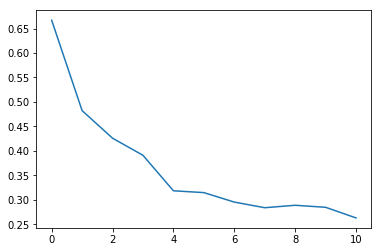

In [20]:
sample_size = X.shape[0]
#n = 8
sil_scores_2=[]
cluster_algo_name_2='kmeans'
for n in range(2,13):
    estimator = KMeans(init='k-means++', n_clusters=n, n_init=10).fit(X)
    sil_score=metrics.silhouette_score(X, estimator.labels_,metric='euclidean',sample_size=sample_size)
    print str(n)+': '+str(sil_score)
    sil_scores_1.append(sil_score)

In [ ]:
cluster_songs=dict()
for cluster_number in range(8):#range(n):
    cluster_songs[cluster_number]=get_songs_in_cluster(df2_valid,input_path+file_training_withsongs,cluster_number)
    print cluster_songs[cluster_number]

In [ ]:
cluster_number=0
all_songs = cluster_songs[cluster_number].iloc[:,1:3]

seed_list=["TREKLEO128F1459433","TRCPWIH128F42424E1","TRKRRUV128F92F20F1","TRRBUQL12903CCE501","TRGTNXU128F1469AEB","TRTLYMG128F92D0138"]

def getSetDiff(seed_list,all_songs):
    output=[]
    for track_id in all_songs.iloc[:,0]:
        if track_id not in seed_list:
            output.append(track_id)
    return output

getSetDiff(seed_list,all_songs)    

In [13]:
filetrain='/home/seherkhan/IdeaProjects/imf552_proj/.idea/FINAL/clustering-13Nov/data/training_triplets_FINAL_min_5.csv'
fileval='/home/seherkhan/IdeaProjects/imf552_proj/.idea/FINAL/clustering-13Nov/data/validation_triplets_seed_min_5.csv'
fileval_check='/home/seherkhan/IdeaProjects/imf552_proj/.idea/FINAL/clustering-13Nov/data/validation_triplets_checking_min_5.csv'

def get_all_predicted_songs(valid_df):
    output=[]
    for index, row in valid_df.iterrows():
        #print row['userID'], row['cluster_number']
        user_songs = get_songs_of_user(filetrain,row['userID']).append(get_songs_of_user(fileval,row['userID']))
        #print user_songs
        cluster_songs_for_user = cluster_songs[row['cluster_number']]
        #print user_songs
        cluster_songs_for_user=cluster_songs_for_user.drop(columns=['index'])
        predicted_songs = getSetDiff(user_songs,  cluster_songs_for_user)
        output.append(predicted_songs)
    return output

In [ ]:
import csv
def set_intersection(valid_df, filetrain, fileeval):
   output=[]
   for index, row in valid_df.iterrows():
       #print row['userID'], row['cluster_number']
       user_songs = get_songs_of_user(filetrain,row['userID']).append(get_songs_of_user(fileval,row['userID']))
       #print user_songs
       cluster_songs_for_user = cluster_songs[row['cluster_number']]
       #print user_songs
       cluster_songs_for_user=cluster_songs_for_user.drop(columns=['index'])
       predicted_songs = getSetDiff(user_songs,  cluster_songs_for_user)
       output.append(predicted_songs)
       #print(predicted_songs)
   with open(fileval_check, 'r') as inp:
       data=csv.reader(inp)
       inp_list=list(data)
   intersection = [] 
   count = 0
   for entry in inp_list:
       for record in output:
           if entry[1]==record:
               intersection.append(record)
               count+=1
   print(count)
   print("Accuracy: ", count/len(inp_list))
   
intersection = set_intersection(df2_valid,filetrain, fileval)